# Reduced coverage experiments
Where the set of entries contrained in one thesaurus is constrained to match another, smaller thesaurus. This lets us look at performance differences due to 

 - higher coverage of space of all words/phrases (due to different filtering or algorithm specifics), versus 
 - better vector quality
 
There are currently (19-5-15) two sets of such experiments, both for NPs only:
 - w2v vectors reduced to the coverage of count-windows vectors
 - count-windows reduced to coverage of Baroni vector

In [1]:
%cd ~/NetBeansProjects/ExpLosion/
from copy import deepcopy
from notebooks.common_imports import *
from gui.output_utils import *
from gui.user_code import pretty_names

/Volumes/LocalDataHD/m/mm/mmb28/NetBeansProjects/ExpLosion


In [2]:
def plot_matching(exp_with_constraints, labels=None, rotation=60):
    matching = []
    for e in exp_with_constraints.values():
        # remove constraint     
        settings = deepcopy(e)
        settings['entries_of_id'] = None
        del settings['id']
        del settings['git_hash']
        del settings['date_ran']
        matching.append(Experiment.objects.get(**settings))
    
    ids1 = list(exp_with_constraints.values_list('id', flat=True))
    ids2 = [x.id for x in matching]
    if not labels:
        labels = ['%s-%s'%(a.id, b.id) for a,b in zip(exp_with_constraints, matching)]
    diff_plot(ids1, ids2, labels, rotation=rotation)

Running significance for experiments [146, 132]
Original difference 0.00500285596038
p-value 0.30400000000000005
Running significance for experiments [148, 133]
Original difference 0.0103525202837
p-value 0.040000000000000036
Running significance for experiments [150, 134]
Original difference 0.00511415261757
p-value 0.262
Running significance for experiments [152, 135]
Original difference 0.0209761585143
p-value

/Volumes/LocalDataHD/m/mm/mmb28/NetBeansProjects/seaborn/seaborn/categorical.py:2642: UserWarning: The `x_order` parameter has been renamed `order`
  UserWarning)

  UserWarning)



 0.0
['W-Mult $\\rightarrow$ Baroni*', 'W-Add $\\rightarrow$ Baroni*', 'W-Left $\\rightarrow$ Baroni*', 'W-Right $\\rightarrow$ Baroni*']


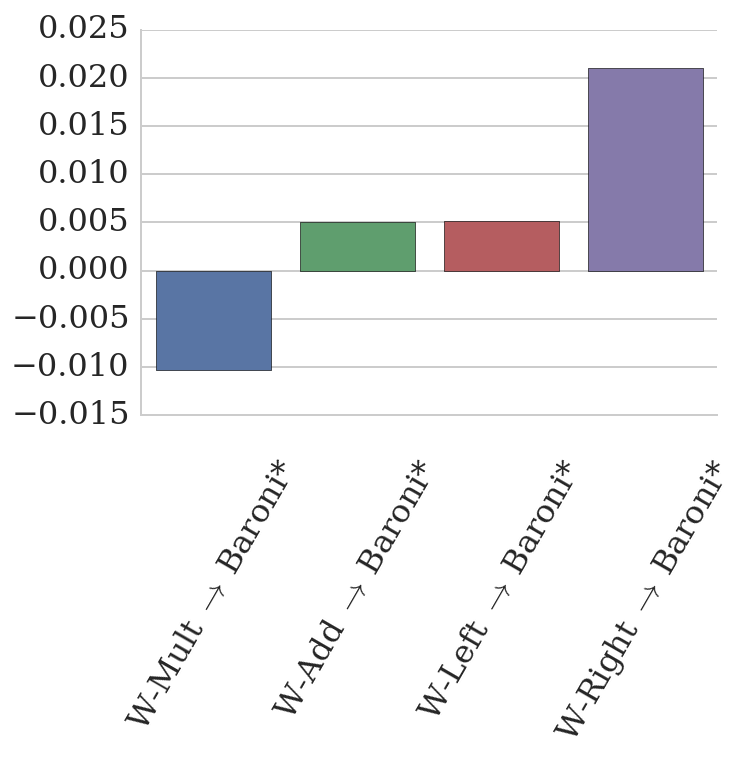

In [3]:
exp_ids = Experiment.objects.filter(entries_of__isnull=False, entries_of__composer='Baroni')
names = pretty_names([x.id for x in exp_ids])
names = [r'%s $\rightarrow$ Baroni' % n for n in names]
plot_matching(exp_ids, labels=names)

Running significance for experiments [145, 97]
Original difference 0.000591545708884
p-value 0.91
Running significance for experiments [147, 107]
Original difference 0.000205744566288
p-value 0.956
Running significance for experiments [149, 117]
Original difference 0.00324479256125
p-value 0.45799999999999996
Running significance for experiments [151, 127]
Original difference 0.00353110855823
p-value

/Volumes/LocalDataHD/m/mm/mmb28/NetBeansProjects/seaborn/seaborn/categorical.py:2642: UserWarning: The `x_order` parameter has been renamed `order`
  UserWarning)

  UserWarning)



 0.41800000000000004
['w2v $\\rightarrow$ W-Left*', 'w2v $\\rightarrow$ W-Add*', 'w2v $\\rightarrow$ W-Mult*', 'w2v $\\rightarrow$ W-Right*']


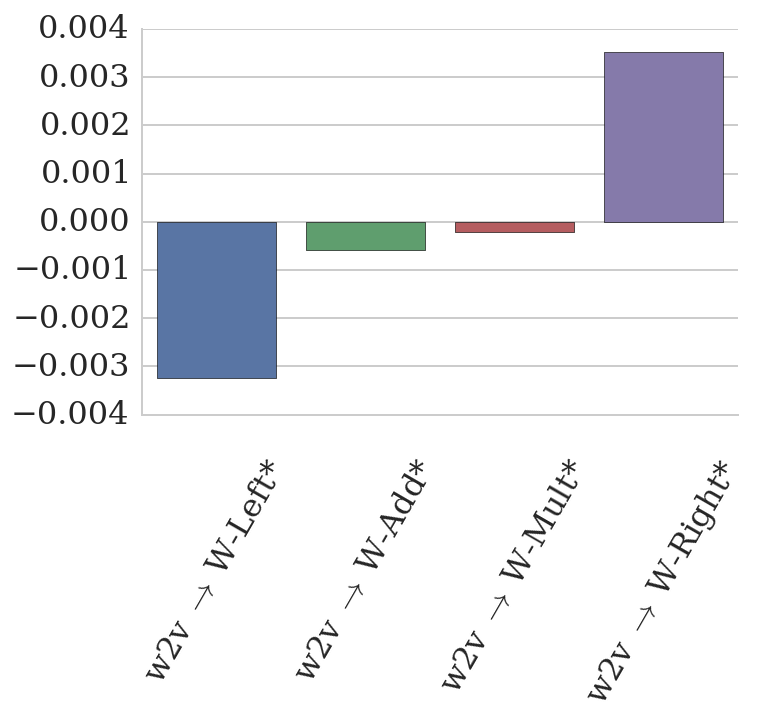

In [4]:
exp_ids = Experiment.objects.filter(entries_of__isnull=False).exclude(entries_of__composer='Baroni')
names = pretty_names([x.id for x in exp_ids], name_format=['vectors__composer'])
names = ['w2v $\\rightarrow$ W-%s' % n for n in names]
plot_matching(exp_ids, labels=names)